Mental Health and the Tech Industry
----------
#### Research Question
Can we predicting if an individual has sought treatment for a mental health condition based on a variety of mental health realted survey responses

Data from Kaggle: https://www.kaggle.com/osmi/mental-health-in-tech-survey

Imports 
-----

In [1]:
import numpy as np
import pandas as pd

from   sklearn.compose         import *
from   sklearn.experimental    import enable_iterative_imputer
from   sklearn.impute          import *
from   sklearn.compose         import TransformedTargetRegressor 
from   sklearn.pipeline        import Pipeline
from   sklearn.preprocessing   import *
from   sklearn.preprocessing   import LabelEncoder
from   sklearn.preprocessing   import StandardScaler
from   sklearn.base            import BaseEstimator
from   sklearn.ensemble        import RandomForestClassifier
from   sklearn.linear_model    import LogisticRegression 
from   sklearn.linear_model    import RidgeClassifier
from   sklearn.model_selection import RandomizedSearchCV
from   sklearn.model_selection import train_test_split
from   sklearn.neighbors       import KNeighborsClassifier
from   sklearn.svm             import SVC
from   sklearn.model_selection import cross_validate
from   sklearn.model_selection import train_test_split
from   sklearn.metrics         import f1_score
from   sklearn.metrics         import roc_auc_score
from   sklearn.metrics         import roc_curve
from   sklearn.inspection      import permutation_importance

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import warnings
warnings.filterwarnings("ignore")

Load Data
----

In [2]:
path = 'https://raw.githubusercontent.com/michellejc/ML_Lab_FinalProject/main/survey.csv'
df = pd.read_csv(path)

Squestering Test Set
----

In [50]:
y = df['treatment']
X = df.drop(columns=['treatment'])

X_train_main, X_test, y_train_main, y_test = train_test_split(X, y, random_state=89)

Converting Target Variable 
----
Transforming the target variable y (has or has not sought treatment) from "yes" or "no" to 0 or 1. Target variable must be converted to numeric values (as do all features)

In [51]:
le = LabelEncoder()
le.fit(y_train_main)

y_train_main = le.transform(y_train_main)
y_test = le.transform(y_test)

Building the Preprocessing Pipeline 
----

In [52]:
# categorical pipeline

# binning age to reduce use as a categorical variable and reduce dimensionality 
bin_column = ['Age'] 
categorical_columns = ['Gender', 'Country', 'state', 'self_employed',
       'family_history', 'work_interfere', 'remote_work',
       'tech_company', 'benefits', 'care_options', 'wellness_program',
       'seek_help', 'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical']

# binning age 
bin_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),      # imputing missing values with the median to handle any missing values and not skew the data with other imputations 
                     ('bin', KBinsDiscretizer(n_bins=7, encode='onehot'))])

# categorical pipeline 
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # imputing any other missing value as missing, missing may have significance and can be tracked if imputed specifically 
                     ('ohe', OneHotEncoder(handle_unknown='ignore'))])

# combining preprocessing steps into one 
preprocessing = ColumnTransformer([('categorical', cat_pipe, categorical_columns),
                                   ('bin', bin_pipe, bin_column)])


Evaluation Metrics 
----
I selected the F1 measure as my first evaluation metric. I choose the F1 score because it balances precision and recall for binary classification, which I feel is appropriate because I do not wish to prioritize precision or recall over the other. Furthermore it's values are always between 0 and 1 with values closer to 1 being better, which I feel is a simple and easy to interpret measure of this model. 

The second metric I track is the ROC score, or area under the Reciever Operating Characteristic curve. I chose this metric because it captures the interaction between the true positive rate and the false positive rate. I was not worried about odd behavior from the ROC curve becuase my dataset is more or less balanced.

Randomized CV Search to select candidate models
----

In [53]:
# helper class for testing different algorithms 
class DummyEstimator(BaseEstimator):
    "Pass through class, methods are present but do nothing."
    def fit(self): pass
    def score(self): pass

In [54]:
# set of classifier algorithms to evaluate 
algorithms = [RandomForestClassifier(),
             LogisticRegression(),
             RidgeClassifier(),
             KNeighborsClassifier(),
             SVC()]

# evaluating each algorithms performance with default parameters as a first step 
for algo in algorithms: 
    pipe = Pipeline([('preprocessing', preprocessing), 
                     ('classifier',  algo)])
    f1_list = []
    roc_list = []
    
    for x in range(20):
        X_train, X_validate, y_train, y_validate = train_test_split(X_train_main, y_train_main)
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_validate)
        f1 = f1_score(y_validate, y_pred)
        f1_list.append(f1)
        
        roc = roc_auc_score(y_validate, y_pred)
        roc_list.append(roc)
    
    average_f1 = sum(f1_list)/len(f1_list)
    average_roc = sum(roc_list)/len(roc_list)
        
    print(f"{algo.__class__.__name__:<17} - f1: {average_f1:,.2f}, roc: {average_roc:,.2f}")

RandomForestClassifier - f1: 0.84, roc: 0.82
LogisticRegression - f1: 0.83, roc: 0.82
RidgeClassifier   - f1: 0.85, roc: 0.83
KNeighborsClassifier - f1: 0.72, roc: 0.72
SVC               - f1: 0.85, roc: 0.83


The top three performing models before hyperparameter tuning are **SVC, RidgeClassifier,** and **RandomForestClassifier**. These models are now the top three candidate models. Next each model will be tuned and a final model will be choosen from the tuned model

Candidate 1: SVC
----

In [55]:
hyperparameters = {'classifier__C': [1.0,2,3,4,5],                            # controls the strength of regularization
                     'classifier__break_ties': [False, True],                 # determines how ties between predictors are broken
                     'classifier__degree': [3,4,5,6,7],                       # degree when kernel is 'poly'
                     'classifier__kernel': ['rbf','linear', 'poly', 'sigmoid', 'precomputed'], # speficies algorithm kernel type
                     'classifier__shrinking': [True, False],                  # determines use of shrinkage heuristic 
                     'classifier__tol': [0.001, 0.01, 0.002, 0.01]}           # tolerance for stopping criterion

# passing data through preprocessing steps and SVC model 
pipe = Pipeline([('preprocessing', preprocessing), 
                 ('classifier',  SVC())])

# conducting random CV search to best performing hyperparameters
clf_rand_cv = RandomizedSearchCV(estimator=pipe, 
                                  scoring ='f1',
                                  param_distributions=hyperparameters, 
                                  n_iter=25,
                                  cv=5, 
                                  n_jobs=-1,
                                  verbose=False)

best_model_svc = clf_rand_cv.fit(X_train_main, y_train_main) 

In [56]:
scoring = ['f1', 'roc_auc']
scores = cross_validate(best_model_svc, X_train_main, y_train_main, cv=5, scoring=scoring)

f1_scores = scores['test_f1']
roc_auc_scores = scores['test_roc_auc']
print("f1 scores %0.2f with a standard deviation of %0.2f" % (f1_scores.mean(), f1_scores.std()))
print("ROC scores %0.2f with a standard deviation of %0.2f" % (roc_auc_scores.mean(), roc_auc_scores.std()))

f1 scores 0.85 with a standard deviation of 0.01
ROC scores 0.87 with a standard deviation of 0.02


Candidate 2: RidgeClassifier
---

In [57]:
hyperparameters = {'classifier__alpha': [1.0, 2,3,4,5],                          # regularization strength 
                    'classifier__class_weight': [None, 'balanced'],              # weights associated to each class (for balancing imbalanced datasets)
                    'classifier__copy_X': [True, False],                         # if True X is copied
                    'classifier__normalize': [False, True],                      # if true regressors are normalized before regression
                    'classifier__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}   # solver used in computational routines

pipe = Pipeline([('preprocessing', preprocessing), 
                 ('classifier',  RidgeClassifier())])


clf_rand_cv = RandomizedSearchCV(estimator=pipe, 
                                  scoring ='f1',
                                  param_distributions=hyperparameters, 
                                  n_iter=25,
                                  cv=5, 
                                  n_jobs=-1,
                                  verbose=False)

best_model_ridge = clf_rand_cv.fit(X_train_main, y_train_main) 

In [58]:
scoring = ['f1', 'roc_auc']
scores = cross_validate(best_model_ridge, X_train_main, y_train_main, cv=5, scoring=scoring)

f1_scores = scores['test_f1']
roc_auc_scores = scores['test_roc_auc']
print("f1 scores %0.2f with a standard deviation of %0.2f" % (f1_scores.mean(), f1_scores.std()))
print("ROC scores %0.2f with a standard deviation of %0.2f" % (roc_auc_scores.mean(), roc_auc_scores.std()))

f1 scores 0.86 with a standard deviation of 0.02
ROC scores 0.88 with a standard deviation of 0.02


Candidate 3: Random Forest Classifier
----

In [61]:
hyperparameters = {'classifier__bootstrap': [True, False],                 # to use or not use bootstrap samples when constructing trees
     'classifier__ccp_alpha': [1.0, 2.0, 0.0],                             # used for Minimal Cost-Complexity Pruning
     'classifier__class_weight': [None, 'balanced', 'balanced_subsample'], # weights associated with classes 
     'classifier__criterion': ['gini', 'entropy'],                         # which loss function to use 
     'classifier__max_depth': [None,2,3,4,5, 6,7],                         # how many nodes a given tree can use
     'classifier__max_leaf_nodes':[None, 2,3,4,5],                         # growing trees with max leaf node in best-first fashion
     'classifier__max_samples': [None,2,3,4,5],                            # if bootstraping - the number of samples drawn from X 
     'classifier__min_samples_leaf': [1,2,3,4,5],                          # min number of targest per leaf
     'classifier__n_estimators': [10, 50, 100, 110, 120, 200, 300, 500],   # number of trees 
     'classifier__warm_start': [False, True]}

pipe = Pipeline([('preprocessing', preprocessing), 
                 ('classifier',  RandomForestClassifier())])

clf_rand_cv = RandomizedSearchCV(estimator=pipe, 
                                  scoring ='f1',
                                  param_distributions=hyperparameters, 
                                  n_iter=25,
                                  cv=5, 
                                  n_jobs=-1,
                                  verbose=False)

best_model_rf = clf_rand_cv.fit(X_train_main, y_train_main) 

In [62]:
scoring = ['f1', 'roc_auc']
scores = cross_validate(best_model_rf, X_train_main, y_train_main, cv=5, scoring=scoring)

f1_scores = scores['test_f1']
roc_auc_scores = scores['test_roc_auc']
print("f1 scores %0.2f with a standard deviation of %0.2f" % (f1_scores.mean(), f1_scores.std()))
print("ROC scores %0.2f with a standard deviation of %0.2f" % (roc_auc_scores.mean(), roc_auc_scores.std()))

f1 scores 0.82 with a standard deviation of 0.03
ROC scores 0.88 with a standard deviation of 0.02


# Results
Final Model: Ridge Classification 
----
All three candidate models performed similarly, however Ridge Classifier slightly out performed SVC and Random Forest Classifier on both the F1 score and the ROC score. 

In [69]:
# displaying the final model including the pipeline and tuned hyperparameters
best_model_ridge

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('categorical',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value='missing',
                                                                                                              strategy='constant')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Gender',
                                                                                'Country',
                       

#### Performance on test set

In [64]:
final_model = best_model_ridge
y_pred = final_model.predict(X_test)
ROC_final_score = roc_auc_score(y_test, y_pred)
F1_final_score = f1_score(y_test, y_pred)

print(f"Final f1 score: {F1_final_score} \nFinal ROC score {ROC_final_score}")

Final f1 score: 0.8411764705882354 
Final ROC score 0.8307453416149069


Both the F1 and ROC scores go down when the model predicts on the test set. This is as expected because the model should perform best on the data that it was trained on.

Nevertheless, with an F1 score and an ROC score well above 0.5 this model does the ability to predict seeking help significantly better than chance.

Feature Importance 
----

Finding the permutation feature importance to get a feel for what features are most important in this model.

In [70]:
r = permutation_importance(final_model, 
                           X_test, y_test,  
                           n_repeats=10)

importances = r.importances_mean
features = X.columns

feat_importances = []
for feature in zip(features, importances):
    feat_importances.append(feature)

selecting the top ten important features in this model to visualize

In [66]:
importances_df = pd.DataFrame(feat_importances)
importances_df.columns = ['feature', 'importance']
importances_df = importances_df.sort_values(by=['importance'], ascending=False)
importances_df= importances_df.drop([3,7,21,25,20,24, 16,4,5,18,15,14,23,22,12,11])

Plotting feature importance 

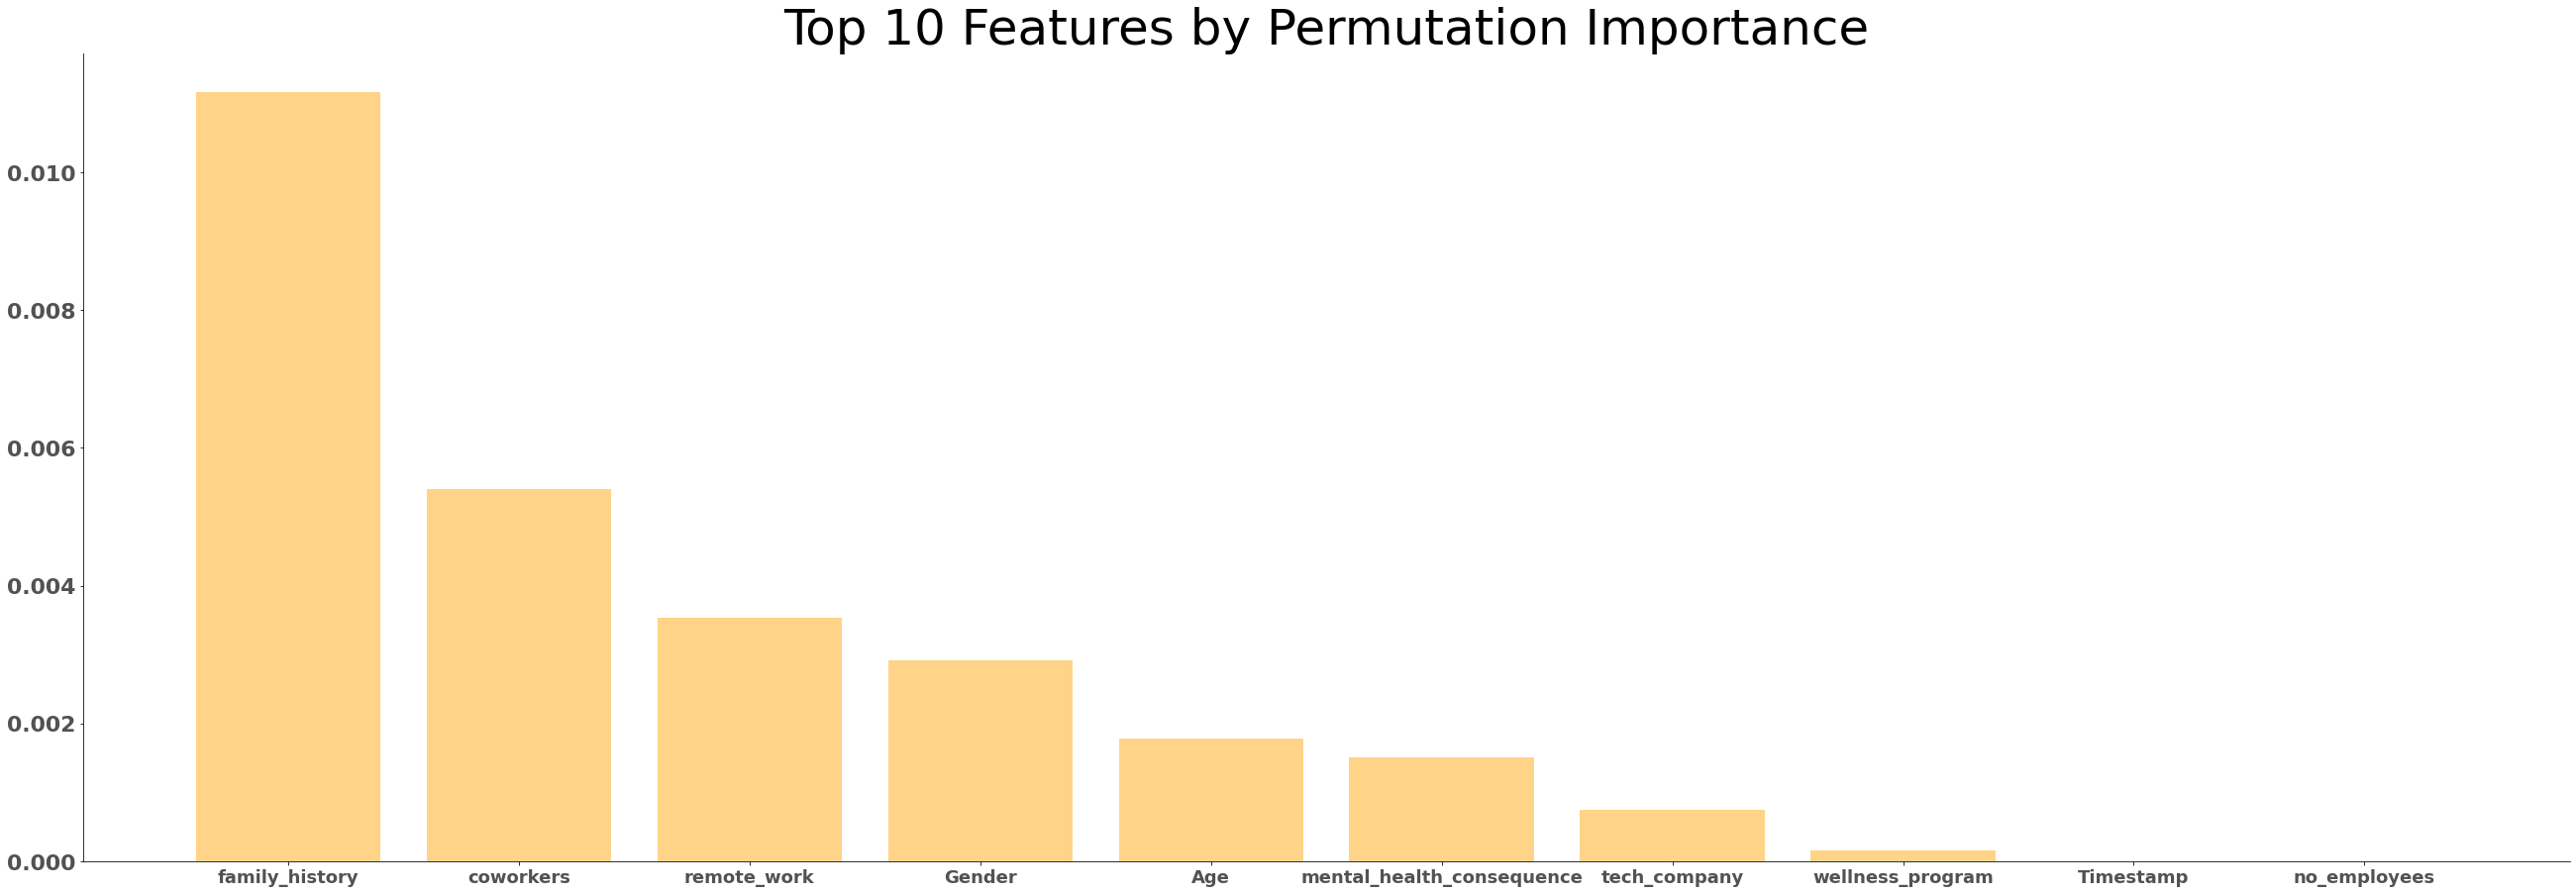

In [75]:
fig, ax = plt.subplots(figsize=(45,15)) 

plt.bar(importances_df['feature'], importances_df['importance'], color='#ffd488')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title("Top 10 Features by Permutation Importance", fontsize=50)
ax.set_xticklabels(importances_df['feature'], fontsize = '18', color = '#525252', fontweight='bold')
ax.set_yticklabels(importances_df['importance'], fontsize = '22', color = '#525252', fontweight = 'bold')

ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

plt.show()

Conclusion
----

This study above attempts to understand if it is possible to predict whether an individual has sought treatment for a mental health condition based on survey responses. Answering this question can help companies understand what employees may need extra help and/or what policies they should implement to increase healthy mental health practices (like seeking help). This information may also help mental health professionals understand clients that work in the tech industry and perhaps know the kinds of individuals that need more outreach or encouragement to seek help.

To answer this question I first conduct a randomizedCV search to pick three candidate models from some of the most common classifier models. This first survey finds three candidate models: **SVC, RidgeClassifier,** and **RandomForestClassifier**. Then I tune the hyperparameters of each model with another random CV search. A final tuned Ridge Classifier performs the best when compared to SVC and Random Forest Classifier using F1 and ROC scores.

These scores (greater than .8 in both cases) suggest that this model is somewhat effective at predicting if an individual has sought treatment (certainly better than chance). Therefore, it may be possible to evaluate someones chances for seaking help without asking them directly. Furthermore, a permutation importance method shows that family history, number of coworkers, and working remotly at leat 50% of the time are the three most important features (at least in the context of this model). Therefore, companies and mental health professionals should dig deeper into these features in future studies.